# Notebook: Create Corpus Analysis 

This notebook is used to create plots using our trained model.
<br>**Contributors:** [Nils Hellwig](https://github.com/NilsHellwig/) | [Markus Bink](https://github.com/MarkusBink/)

## Packages

In [1]:
import matplotlib.pyplot as plt
from plots import plot_overall_sentiment, plot_sentiment
import pandas as pd

## Parameters

In [2]:
PLOTS_PATH = "../Plots/"

## Code

### Create Figure with Bar Charts (Overall Sentiment Distribution)

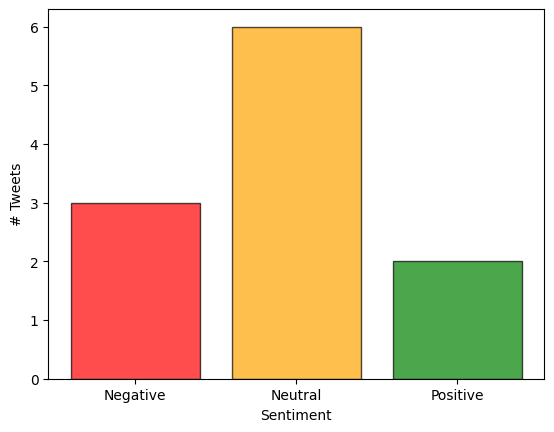

In [3]:
data = [3, 6, 2]
filename = PLOTS_PATH + "overall_sentiment"
plot_overall_sentiment(data, filename)

### Create Figure for Percentage Distribution of Sentiment Classes

In [4]:
import pandas as pd
import random

sentiment = ['positive', 'negative', 'neutral'] * 36
party = ['CDU/CSU', 'SPD', 'AfD', 'FDP', 'Die Linke', 'Grüne'] * 18
random.shuffle(sentiment)
random.shuffle(party)
data = {'sentiment': sentiment, 'party': party}
df = pd.DataFrame(data)
df

,sentiment,party
0,positive,Grüne
1,neutral,CDU/CSU
2,neutral,Die Linke
3,negative,Die Linke
4,neutral,AfD
...,...,...
103,neutral,AfD
104,negative,FDP
105,neutral,Die Linke
106,negative,SPD


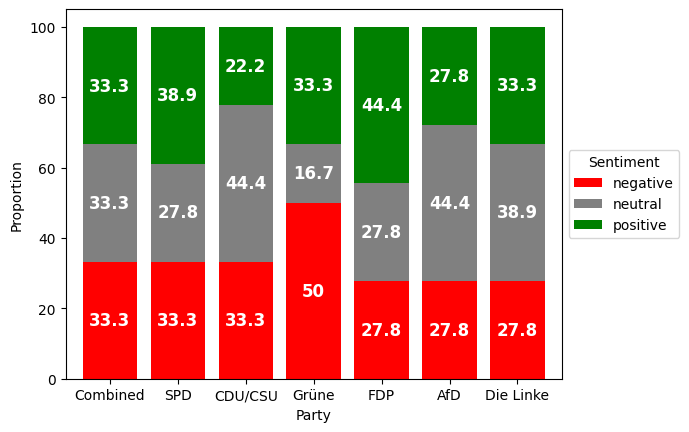

In [5]:
filename = PLOTS_PATH + "proportion_sentiment_parties"
plot_sentiment(df, filename)